In [39]:
##############
## imports ##
##############

import random
import simpy
import numpy as np
import matplotlib.pyplot as plt

constants in our simulation

In [40]:
NUM_SERVERS = 4
SERVICE_TIME_LOW = 5.0
SERVICE_TIME_HIGH = 9.0
ARRIVAL_INTERVAL_LOW = 8.0
ARRIVAL_INTERVAL_HIGH = 12.0
SIM_TIME = 1000

# setting a random seed will ensure our psuedocode is replicable
np.random.seed(44)

Let's initialize some stats list

In [41]:
waiting_times = []
in_system = 0
in_system_times = []

Let's define our customer

In [42]:
class Customer(object):
    def __init__(self, name, env, out_pipe):
        self.name = name
        self.env = env
        self.out_pipe = out_pipe

    def visit(self, time_in_bank_low, time_in_bank_high):
        yield self.env.timeout(np.random.uniform(time_in_bank_low, time_in_bank_high))
        print(f'Customer {self.name} finished at {self.env.now}')

Let's define our Bank Servers

In [43]:
class Bank(object):
    def __init__(self, env, num_servers, service_time_low, service_time_high, out_pipe):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.service_time_low = service_time_low
        self.service_time_high = service_time_high
        self.out_pipe = out_pipe
        self.total_working_time = 0.0
        self.num_customers = 0

    def serving(self, customer):
        global in_system
        arrival_time = self.env.now
        with self.server.request() as req:
            start_time = self.env.now
            yield req
            in_system += 1
            self.total_working_time += self.env.now - start_time
            waiting_times.append(self.env.now - arrival_time)
            yield self.env.timeout(np.random.uniform(self.service_time_low, self.service_time_high))
            print(f'Served customer {customer.name} at {self.env.now}')
            yield self.out_pipe.put((customer.name, arrival_time, self.env.now))
            in_system -= 1
            self.num_customers += 1

Define our Source

In [44]:
def customer_generator(env, bank, interval_low, interval_high):
    i = 0
    while True:
        i += 1
        c = Customer(f'Customer {i}', env, bank.out_pipe)
        env.process(bank.serving(c))
        env.process(c.visit(interval_low, interval_high))
        yield env.timeout(np.random.uniform(interval_low, interval_high))

def monitor(env, in_pipe):
    while True:
        message = yield in_pipe.get()
        print(f'Customer {message[0]} arrival time was {message[1]} and finished at {message[2]}')
        in_system_times.append((env.now, in_system))


Let's simulate

In [45]:
# Setup and start the simulation
env = simpy.Environment()
pipe = simpy.Store(env)
bank = Bank(env, NUM_SERVERS, SERVICE_TIME_LOW, SERVICE_TIME_HIGH, pipe)
env.process(customer_generator(env, bank, ARRIVAL_INTERVAL_LOW, ARRIVAL_INTERVAL_HIGH))
env.process(monitor(env, pipe))
print('Bank system started')
env.run(until=SIM_TIME)

print(f'Average Waiting Time: {np.mean(waiting_times)}')
print(f'Maximum Waiting Time: {np.max(waiting_times)}')
print(f'Server Utilization: {bank.total_working_time / SIM_TIME}')
print(f'Number of Customers Served: {bank.num_customers}')
avg_in_system = np.mean([t[1] for t in in_system_times])
print(f'Time-average number in the system: {avg_in_system}')

Bank system started
Served customer Customer 1 at 7.978561926718071
Customer Customer 1 arrival time was 0 and finished at 7.978561926718071
Customer Customer 1 finished at 96.62539242761956
Served customer Customer 2 at 442.80371050333395
Customer Customer 2 arrival time was 435.36675698086134 and finished at 442.80371050333395
Customer Customer 2 finished at 650.0869857238067
Served customer Customer 3 at 657.6787546421364
Customer Customer 3 arrival time was 650.6391450037779 and finished at 657.6787546421364
Served customer Customer 4 at 888.1793411444824
Customer Customer 4 arrival time was 881.3528567087266 and finished at 888.1793411444824
Customer Customer 3 finished at 888.4488359792349
Average Waiting Time: 0.0
Maximum Waiting Time: 0.0
Server Utilization: 0.0
Number of Customers Served: 4
Time-average number in the system: 0.0


Let's visualize our waiting time

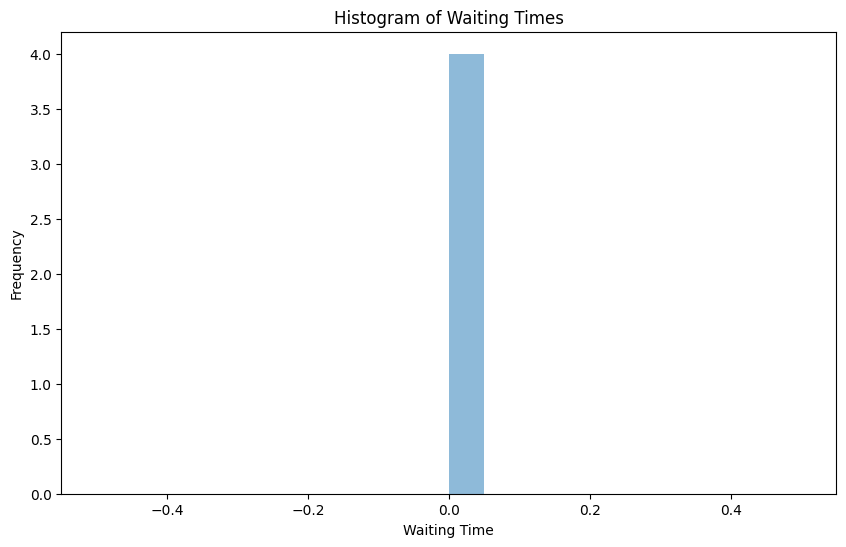

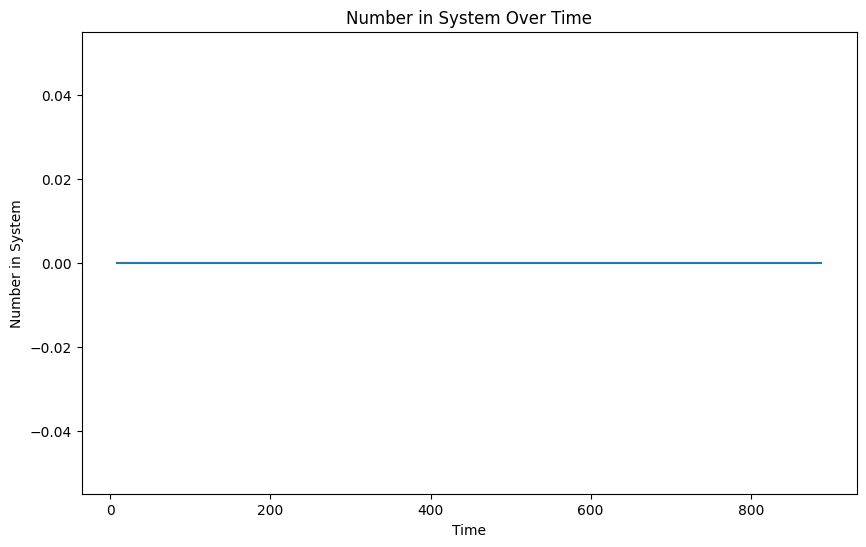

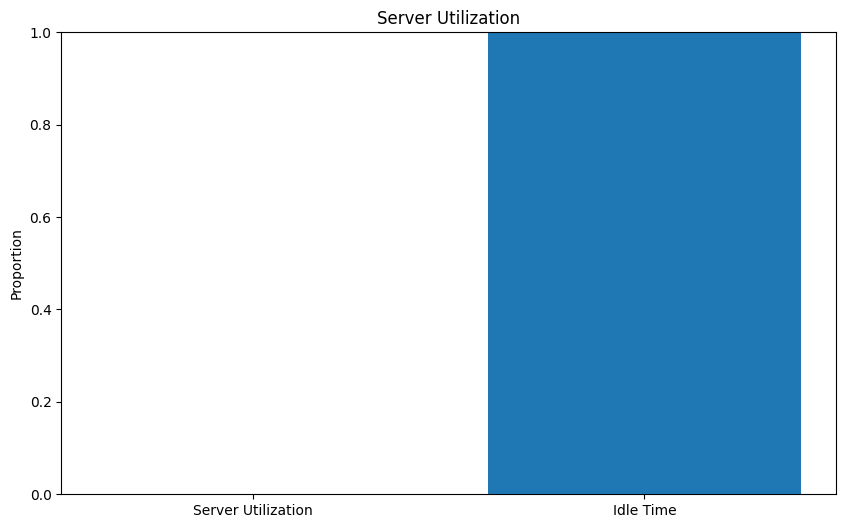

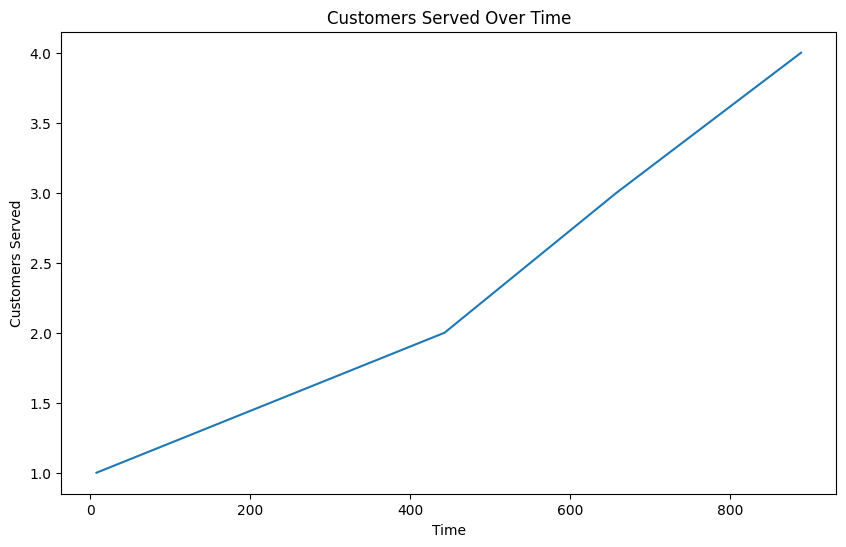

In [46]:
# Histogram of waiting times
plt.figure(figsize=(10, 6))
plt.hist(waiting_times, bins=20, alpha=0.5)
plt.title('Histogram of Waiting Times')
plt.xlabel('Waiting Time')
plt.ylabel('Frequency')
plt.show()

# Line plot of number in system over time
times, nums_in_system = zip(*in_system_times)
plt.figure(figsize=(10, 6))
plt.plot(times, nums_in_system)
plt.title('Number in System Over Time')
plt.xlabel('Time')
plt.ylabel('Number in System')
plt.show()

# Bar chart of server utilization
plt.figure(figsize=(10, 6))
plt.bar(['Server Utilization', 'Idle Time'], [bank.total_working_time / SIM_TIME, 1 - bank.total_working_time / SIM_TIME])
plt.title('Server Utilization')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

# Line plot of customers served over time
cumulative_customers_served = np.cumsum([1 for _ in waiting_times])
plt.figure(figsize=(10, 6))
plt.plot(times, cumulative_customers_served)
plt.title('Customers Served Over Time')
plt.xlabel('Time')
plt.ylabel('Customers Served')
plt.show()


Let's visualize service times

Let's visualize server utilization